## Feature Engineering

From the initial dataset only RET_1 through RET_5 are kept as well as VOLUME_1. The rest of the features calculated below are based only on RET_1 and aggregation by date, sector and industry in order to reduce noise and capture market dynamics. Certain features proved to be consistently significant such as sector_market_beta and sector_dispersion and that is why interaction features between them were introduced that were also significant. The importance of features was identified by fitting the dataset to a RandomForestCLassifier.

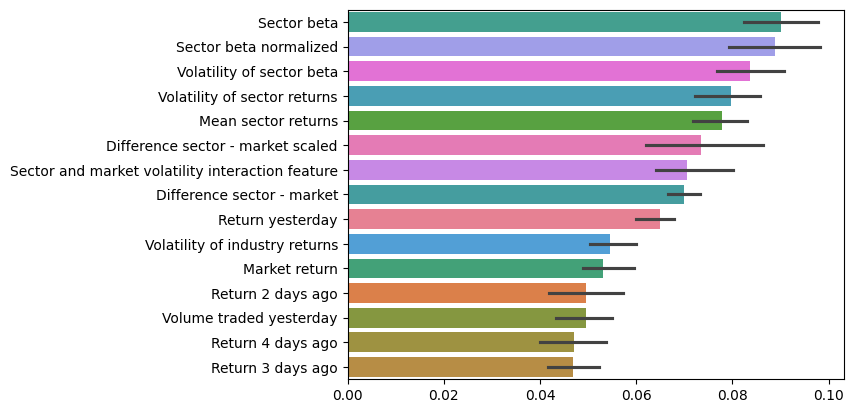

In [1]:
import numpy as np
import pandas as pd

def feature_engineering(dataset):

    df = pd.DataFrame()
    df['DATE'] = dataset['DATE']
    df['SECTOR'] = dataset['SECTOR']
    df['INDUSTRY'] = dataset['INDUSTRY']

    for i in range(1, 5):
        df[f'ret_{i}'] = dataset[f'RET_{i}']
    df['volume_1'] = dataset[f'VOLUME_1']
    
    # Sector-specific features and overall market measures
    df['sector_ret_mean'] = df.groupby(['SECTOR', 'DATE'])['ret_1'].transform('mean')
    df['market_ret'] = df.groupby('DATE')['ret_1'].transform('mean')
    df['sector_beta'] = df['sector_ret_mean'] / (df['market_ret'] + 1e-8)
    df['sector_vs_market'] = df['sector_ret_mean'] - df['market_ret']
    
    # Calculate sector and industry standard deviation without outliers potentially introducing noise
    df['sector_dispersion'] = df.groupby(['SECTOR', 'DATE'])['ret_1'].transform(lambda x: x.clip(lower=x.quantile(0.1), upper=x.quantile(0.9)).std())
    df['industry_dispersion'] = df.groupby(['INDUSTRY', 'DATE'])['ret_1'].transform(lambda x: x.clip(lower=x.quantile(0.1), upper=x.quantile(0.9)).std())
    
    # Interactions between most significant features that proved to be significant as well
    df['sector_beta_dispersion'] = df['sector_beta'] * df['sector_dispersion']
    df['sector_relative_dispersion'] = df['sector_dispersion'] / (df.groupby('DATE')['ret_1'].transform('std') + 1e-8)
    df['sector_beta_dispersion_ratio'] = df['sector_beta_dispersion'] / (df.groupby('DATE')['sector_beta_dispersion'].transform('mean') + 1e-8)
    df['sector_vs_market_scaled'] = df['sector_vs_market'] / (df['sector_dispersion'] + 1e-8)
    
    df = df.drop(columns=['DATE', 'SECTOR', 'INDUSTRY'])
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

In [2]:
train_dataset = pd.read_csv('./data/x_train.csv', index_col='ID')
train_labels = pd.read_csv('./data/y_train.csv', index_col='ID')
test_dataset = pd.read_csv('./data/x_test.csv', index_col='ID')

train_features = feature_engineering(train_dataset)
train_features = pd.concat([train_dataset['DATE'], train_features], axis=1)
train_features

,DATE,ret_1,ret_2,ret_3,ret_4,volume_1,sector_ret_mean,market_ret,sector_beta,sector_vs_market,sector_dispersion,industry_dispersion,sector_beta_dispersion,sector_relative_dispersion,sector_beta_dispersion_ratio,sector_vs_market_scaled
ID,,,,,,,,,,,,,,,,
0,0,-0.015748,-0.015504,0.010972,-0.014672,0.147931,0.009178,0.008915,1.029562,0.000264,0.014356,0.017382,0.014780,0.505130,0.893016,0.018358
1,0,0.003984,-0.090580,0.018826,-0.025540,NaN,0.006477,0.008915,0.726580,-0.002437,0.019871,0.021126,0.014438,0.699175,0.872314,-0.122665
2,0,0.000440,-0.058896,-0.009042,0.024852,-0.096282,0.013449,0.008915,1.508620,0.004534,0.021352,0.020658,0.032212,0.751304,1.946251,0.212354
3,0,0.031298,0.007756,-0.004632,-0.019677,-0.429540,0.017253,0.008915,1.935385,0.008339,0.017941,0.016959,0.034724,0.631297,2.097995,0.464769
4,0,0.027273,-0.039302,0.000000,0.000000,-0.847155,0.006241,0.008915,0.700075,-0.002674,0.011470,0.008916,0.008030,0.403594,0.485169,-0.233102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418590,223,0.021843,-0.021703,0.011141,0.021379,-0.217823,0.016746,0.016865,0.992954,-0.000119,0.013778,0.011424,0.013681,0.438173,0.751510,-0.008623
418591,223,-0.006920,0.000000,0.006968,0.009143,-0.375251,0.012887,0.016865,0.764135,-0.003978,0.012595,0.027004,0.009625,0.400551,0.528674,-0.315816
418592,223,0.021869,-0.005929,0.010989,0.006030,-0.978856,0.024201,0.016865,1.435001,0.007336,0.015243,0.018098,0.021874,0.484745,1.201506,0.481290


## Neural network

The model is a fully connected neural network with three hidden layers. The activation function used is ReLu to capture non-linearities in the data. Batch normalization and dropout rates also help improve performance. The values for the different parameters were chosen through hyperparameter tuning. The depth of the network was also chosen based on its performance in cross-validation (shown in the next cell).

In [3]:
import torch.nn as nn

class DenseNetwork(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.3):
        super(DenseNetwork, self).__init__()
    
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.fc_layers(input)

## Cross Validation

This cross validation loop helps identify the performance of the model and give an idea of what the accuracy will be on the test set. It is a 4-fold cross validation. The training and validation data are scaled separately to avoid data leakage and capped to avoid the distorting effects of outliers. 

For the binary classification, I chose the BCELoss as the most appropriate loss function and trained the model for 5 epochs. The batch size of 512 was tuned after trying several other sizes. The same is true for the number of epochs.

The validation accuracy is equal to 51.49%.

In [8]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

x_train = train_features.to_numpy()
unique_groups = np.unique(x_train[:, 0])
np.random.seed(42)
np.random.shuffle(unique_groups)

groups = x_train[:, 0]

fold_results = []
predictions = [] 
num_folds = 4
group_kfold = GroupKFold(n_splits=num_folds)

for fold, (train_idx, val_idx) in enumerate(group_kfold.split(x_train[:, 1:], train_labels.to_numpy().astype(int), groups=groups)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Separate scaling of training and validation set
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train[train_idx, 1:])
    x_val_scaled = scaler.transform(x_train[val_idx, 1:])
    x_train_scaled[np.isnan(x_train_scaled)] = np.nanmean(x_train_scaled, axis=0)[np.isnan(x_train_scaled).nonzero()[1]]
    x_val_scaled[np.isnan(x_val_scaled)] = np.nanmean(x_val_scaled, axis=0)[np.isnan(x_val_scaled).nonzero()[1]]
    x_train_scaled = x_train_scaled.clip(-3, 3)
    x_val_scaled = x_val_scaled.clip(-3, 3) 

    # Conversion to Pytorch tensors
    x_cv_train = torch.tensor(x_train_scaled).float()
    y_cv_train = torch.tensor(train_labels.to_numpy()[train_idx]).long()
    x_cv_val = torch.tensor(x_val_scaled).float()

    # Batch size is 512
    training_dataset = TensorDataset(x_cv_train, y_cv_train)
    train_loader = DataLoader(training_dataset, batch_size=512, shuffle=True)

    epochs = 5
    model = DenseNetwork(15)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features).squeeze()
            loss = criterion(outputs, batch_labels.squeeze().float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            predictions_batch = (outputs > 0.5).float()
            correct += (predictions_batch == batch_labels.squeeze()).sum().item()
            total += batch_labels.size(0)

        train_accuracy = correct / total * 100
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation loop
    model.eval()
    with torch.no_grad():
        outputs = model(x_cv_val).squeeze()
        val_probs = outputs.numpy()
        val_labels = train_labels.to_numpy()[val_idx]
        
    # Median-based classification per date
    val_correct = 0
    val_total = 0
    for date in np.unique(groups[val_idx]):
        date_mask = groups[val_idx] == date
        date_probs = val_probs[date_mask]
        date_labels = val_labels[date_mask].ravel()

        median = np.median(date_probs) 
        classified = date_probs > median
        val_correct += (classified == date_labels).sum()
        val_total += len(date_labels)

    val_accuracy = (val_correct / val_total) * 100
    print(f"Fold {fold + 1}/{num_folds} - Validation Accuracy: {val_accuracy:.2f}%")
    
    fold_results.append(val_accuracy)

print(f"\nCross-Validation Results: {np.mean(fold_results):.2f}% ± {np.std(fold_results):.2f}%")

Fold 1/4
Epoch 1/5 - Loss: 0.6949, Accuracy: 51.13%
Epoch 2/5 - Loss: 0.6916, Accuracy: 52.07%
Epoch 3/5 - Loss: 0.6911, Accuracy: 52.41%
Epoch 4/5 - Loss: 0.6909, Accuracy: 52.54%
Epoch 5/5 - Loss: 0.6902, Accuracy: 52.78%
Fold 1/4 - Validation Accuracy: 51.36%
Fold 2/4
Epoch 1/5 - Loss: 0.6940, Accuracy: 51.18%
Epoch 2/5 - Loss: 0.6921, Accuracy: 51.94%
Epoch 3/5 - Loss: 0.6915, Accuracy: 52.24%
Epoch 4/5 - Loss: 0.6909, Accuracy: 52.46%
Epoch 5/5 - Loss: 0.6907, Accuracy: 52.71%
Fold 2/4 - Validation Accuracy: 52.10%
Fold 3/4
Epoch 1/5 - Loss: 0.6940, Accuracy: 51.18%
Epoch 2/5 - Loss: 0.6916, Accuracy: 52.17%
Epoch 3/5 - Loss: 0.6912, Accuracy: 52.60%
Epoch 4/5 - Loss: 0.6907, Accuracy: 52.71%
Epoch 5/5 - Loss: 0.6905, Accuracy: 52.82%
Fold 3/4 - Validation Accuracy: 51.49%
Fold 4/4
Epoch 1/5 - Loss: 0.6946, Accuracy: 51.48%
Epoch 2/5 - Loss: 0.6914, Accuracy: 52.40%
Epoch 3/5 - Loss: 0.6909, Accuracy: 52.52%
Epoch 4/5 - Loss: 0.6904, Accuracy: 52.75%
Epoch 5/5 - Loss: 0.6900, Accu

## Training and Prediction

The model is finally trained on the whole dataset before prediction. The accuracy on the test set is 51.64%.

In [5]:
train_features = train_features.drop(columns=['DATE'])
test_features = feature_engineering(test_dataset)

# Retrain the model on the full training dataset
model = DenseNetwork(15)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scaler = StandardScaler()
x_train = scaler.fit_transform(train_features)
x_test = scaler.transform(test_features)
x_train[np.isnan(x_train)] = np.nanmean(x_train, axis=0)[np.isnan(x_train).nonzero()[1]]
x_test[np.isnan(x_test)] = np.nanmean(x_test, axis=0)[np.isnan(x_test).nonzero()[1]]
x_train = x_train.clip(-3, 3)
x_test = x_test.clip(-3, 3)  

x_train = torch.tensor(x_train).float()
x_test = torch.tensor(x_test).float()
y_train = torch.tensor(train_labels.to_numpy().astype(int)).long()

full_train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(full_train_dataset, batch_size=512, shuffle=True)

# Train the model
epochs = 5
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for batch_features, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features).squeeze()
        loss = criterion(outputs, batch_labels.squeeze().float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        predictions = (outputs > 0.5).float()
        correct += (predictions == batch_labels.squeeze()).sum().item()
        total += batch_labels.size(0)

    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

model.eval()
with torch.no_grad():
    outputs = model(x_test).squeeze()
    predictions = (outputs > 0.5).float()

predictions_list = predictions.cpu().numpy().astype(bool).tolist()

predictions_df = pd.DataFrame({
    'ID': test_features.index, 
    'RET': predictions_list
})
predictions_df.to_csv('submission.csv', index=False)
predictions_df


Epoch 1/5, Loss: 0.6938, Accuracy: 51.16%
Epoch 2/5, Loss: 0.6920, Accuracy: 51.93%
Epoch 3/5, Loss: 0.6916, Accuracy: 52.18%
Epoch 4/5, Loss: 0.6911, Accuracy: 52.40%
Epoch 5/5, Loss: 0.6907, Accuracy: 52.64%


,ID,RET
0,418595,False
1,418596,False
2,418597,True
3,418598,False
4,418599,False
...,...,...
198424,617019,True
198425,617020,True
198426,617021,True
198427,617022,False
